
# Ungraded Lab: Variational Autoencoders

This lab will demonstrate all the concepts you learned this week. You will build a Variational Autoencoder (VAE) trained on the MNIST dataset and see how it is able to generate new images. This will be very useful for this week's assignment. Let's begin!


https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/4-Generative-deeplearning-with-tensorflow/week-3/C4_W3_Lab_1_VAE_MNIST.ipynb

In [1]:


import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import ( Conv2D, Conv2DTranspose, Layer, Input, Reshape,
                                      BatchNormalization, Dense, MaxPool2D, Flatten)
from tensorflow.keras.models import Model
from IPython import display



In [2]:


# Define global constants to be used in this notebook
BATCH_SIZE=128
LATENT_DIM=2


def map_image(image, label):
  '''returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))
  
  return image


def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)
  
  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [3]:


train_dataset = get_dataset(map_image)



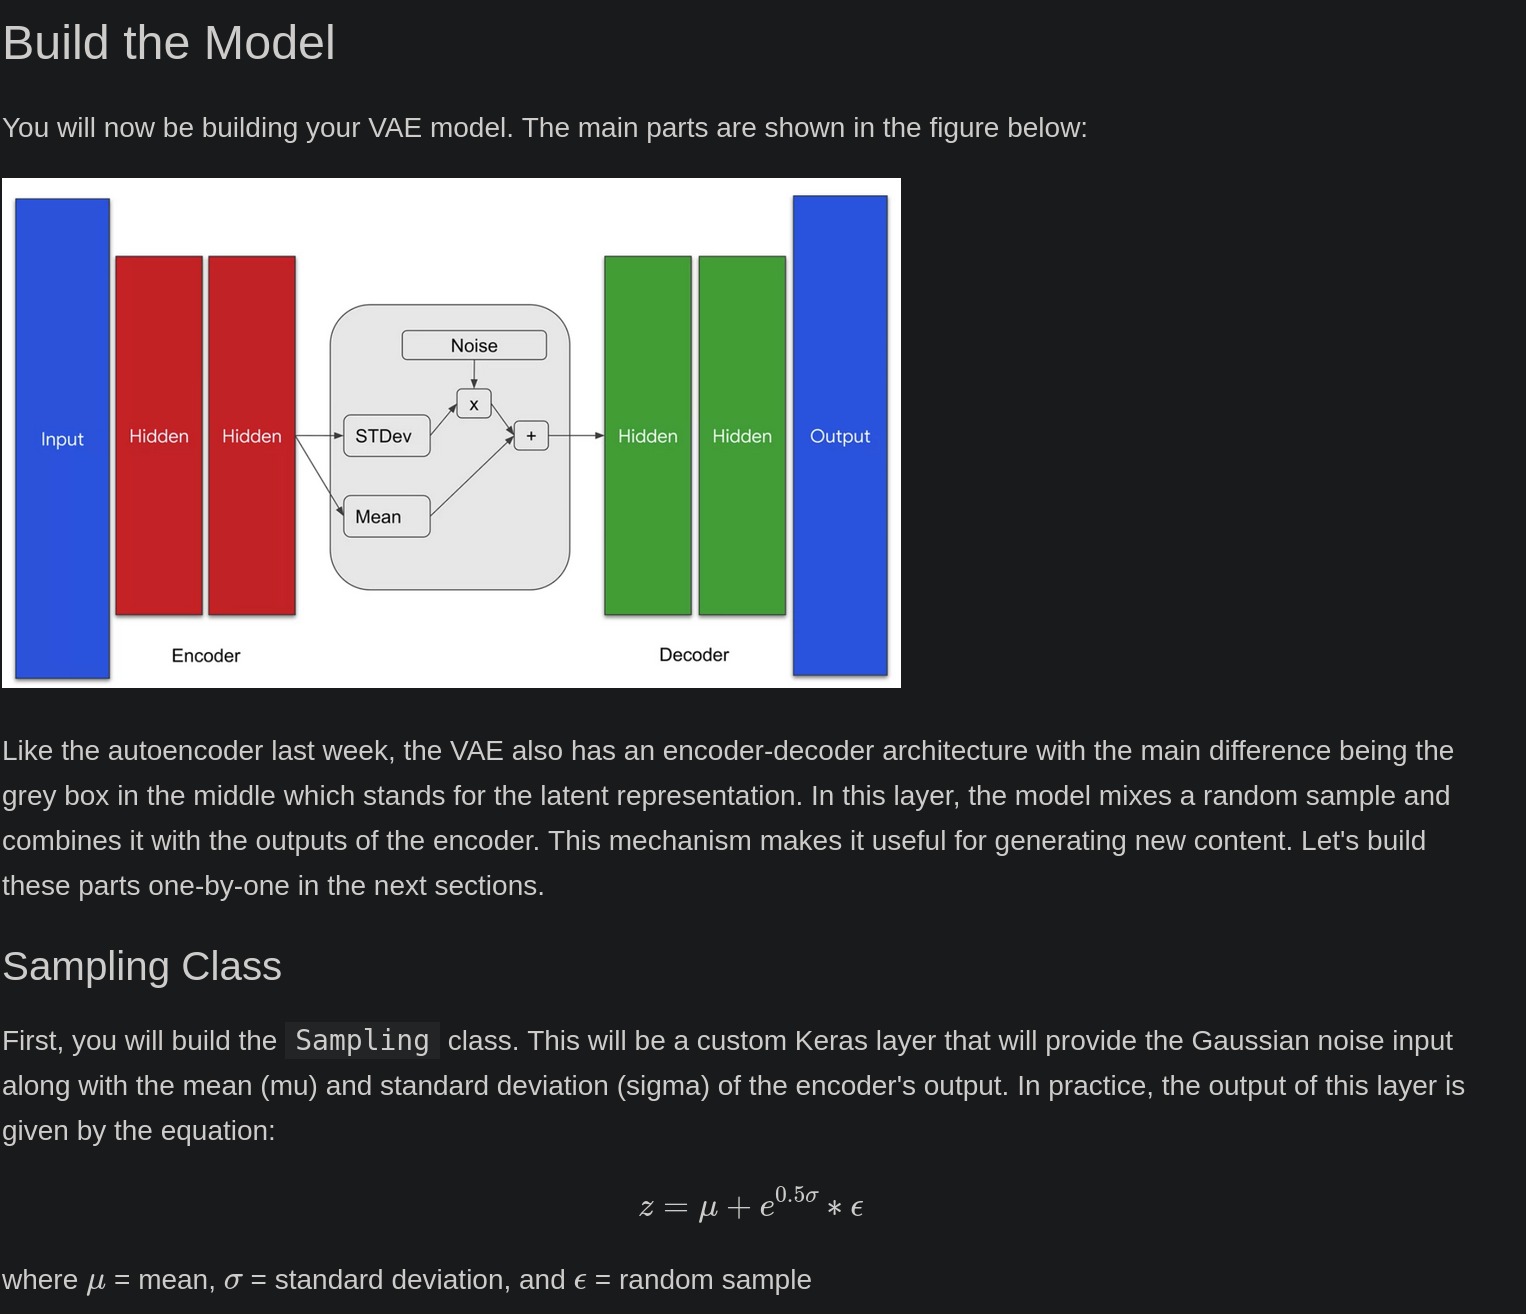

In [4]:
class Sampling(Layer):
    def call(self, inputs):
        ''' Genereates a random sample and combines it with the mean and std-dev from encoder output
        
        Args:
            inputs: output tensor from encoder
        Returns:
            a tensor made of combining `inputs` with  gaussian noise
            
        '''
        # mean is mu and sigma is standard deviation
        mean, sdev = inputs
        # get the size and dimensions of the batch
        batch, dim = tf.shape(mean)[0], tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return mean + tf.exp(0.5 * sdev)* epsilon
    

# Encoder

Next, you will build the encoder part of the network. You will follow the architecture shown in class which looks like this. Note that aside from mu and sigma, you will also output the shape of features before flattening it. This will be useful when reconstructing the image later in the decoder.

Note: You might encounter issues with using batch normalization with smaller batches, and sometimes the advice is given to avoid using batch normalization when training VAEs in particular. Feel free to experiment with adding or removing it from this notebook to explore the effects.
<style>
img{width: 15px;}
</style>

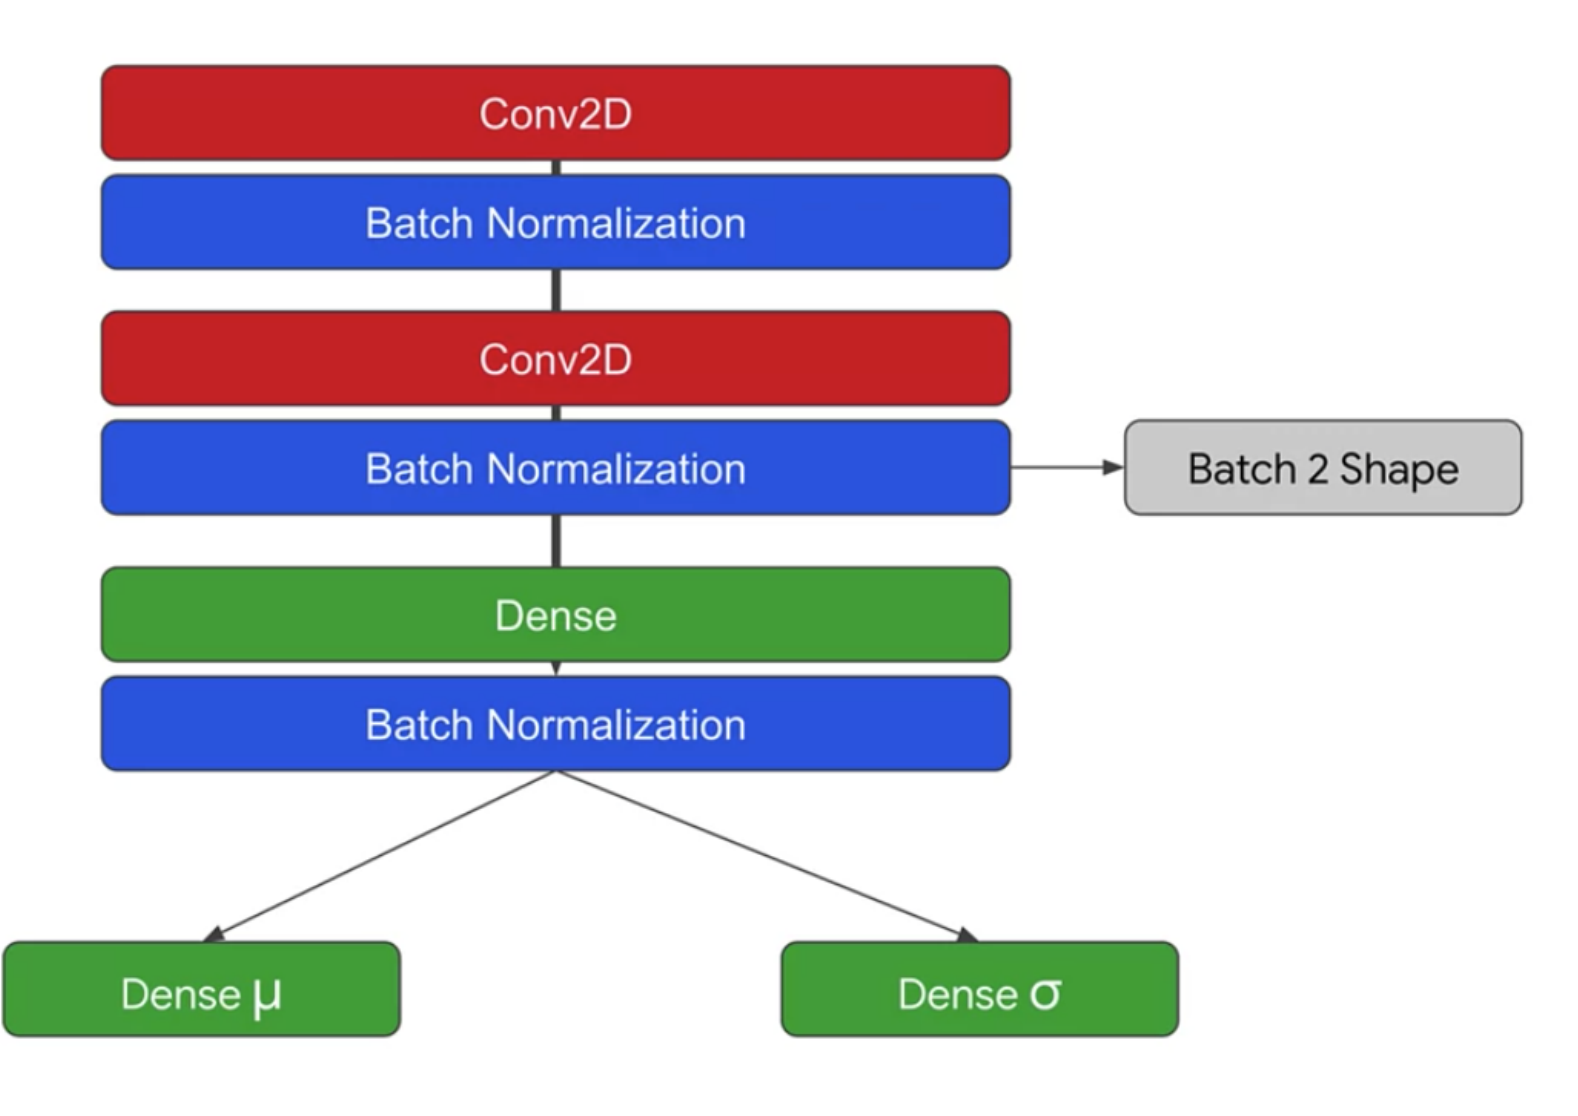

In [5]:
def encoder_layers(inputs, latent_dim):
    '''
        Args:
            inputs: batch from dataset
            latent_dim: dim of latent space
        Returns:
            mu: learned mean
            sigma: leanred std dev
            batch_2.shape: the sampe of features before flattening
    '''
    k = 3 # kernel size
    s= 2 # strides
    p = "same" #padding
    a = 'relu' # activation
    
    x = Conv2D(filters=32, kernel_size=k, strides=s, padding=p, activation=a)(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=k, strides=s, padding=p, activation=a)(x)
    
    # we want to retain this shape, so assign to a different var for later
    batch_norm_2 = BatchNormalization()(x)
    
    x = Flatten(name="encode_flatten")(batch_norm_2)
    # we arbitrarily use 20, pick whatever u fancy
    x = Dense(20, activation=a, name="encode_dense")(x)
    x = BatchNormalization()(x)
    mu = Dense(latent_dim, name="latent_mu")(x)
    sigma = Dense(latent_dim, name="latent_sigma")(x)
    
    return mu, sigma, batch_norm_2.shape
    

In [6]:
def encoder_model(latent_dim,input_shape):
    '''Defines the encoder model with the sampling layer
    Args:
        latent_dim: Tensor
        input_shape: Tensor, shape of dataset batch
    Returns:
        model
        conv_shape, shape of the features before flattening
    '''
    inputs = Input(shape=input_shape)
    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)
    z = Sampling()( (mu, sigma) )
    model = Model(inputs, outputs = [mu, sigma, z])
    return model, conv_shape


# Decoder

Next, you will build the decoder part of the network which expands the latent representations back to the original image dimensions. As you'll see later in the training loop, you can feed random inputs to this model and it will generate content that resemble the training data.


In [7]:

def decoder_layers(inputs, conv_shape):
    """
    Args:
        inputs -- output of the encoder
        conv_shape -- shape of the features before flattening
        
    Returns
        Tensor -- decoded output
    """
    a = 'relu'
    a2 = "sigmoid"
    p='same'
    k = 3
    
    # feed to a Dense network with units computed from the conv_shape dimensions
    units = conv_shape[0] * conv_shape[1] * conv_shape[2]
    x = Dense(units, activation=a, name="decode_dense1")(inputs)
    x = BatchNormalization()(x)
    
    # reshape using conv shape
    x = Reshape((conv_shape[0], conv_shape[1], conv_shape[2]), name="decode_reshape")(x)
    
    # upsample to original dimensions
    x = Conv2DTranspose(filters=64, kernel_size=k, strides=2, padding=p, activation=a, name="decode_conv_1")(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=32, kernel_size=k, strides=2, padding=p, activation=a, name="decode_conv_2")(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=1, kernel_size=k, strides=1, padding=p, activation=a2, name="decode_final")(x)
    
    return x
    

In [8]:


def decoder_model(latent_dim, conv_shape):
    """Defines the decoder model.
    Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

    Returns:
    model -- the decoder model
    """
    inputs = Input(shape=(latent_dim,))
    outputs = decoder_layers(inputs, conv_shape)
    model = Model(inputs,outputs)
    return model



## Kullback–Leibler Divergence

To improve the generative capability of the model, you have to take into account the random normal distribution introduced in the latent space. For that, the Kullback–Leibler Divergence is computed and added to the reconstruction loss. The formula is defined in the function below.
https://arxiv.org/abs/2002.07514


In [9]:


def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss




## VAE Model

You can now define the entire VAE model. Note the use of model.add_loss() to add the KL reconstruction loss. Computing this loss doesn't use y_true and y_pred so it can't be used in model.compile().


In [10]:
def vae_model(encoder, decoder, input_shape):
    """Defines the VAE model
    Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

    Returns:
    the complete VAE model
    """
    inputs = Input(shape=input_shape)
    mu, sigma, z = encoder(inputs)
    reconstructed = decoder(z)
    model = Model(inputs, outputs=reconstructed)
    # add the loss
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)
    return model

In [11]:
# just a helper
def get_models(input_shape, latent_dim):
    """Returns the encoder, decoder, and vae models"""
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
    # remove the batches axis by taking the last three elems in right to left order
    conv_shape = (conv_shape[-3], conv_shape[-2], conv_shape[-1])
    print(conv_shape)
    
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    return encoder, decoder, vae



# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)



(7, 7, 64)


In [12]:


# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()



In [19]:

plt.rcParams['figure.facecolor']='w'
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))


  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()



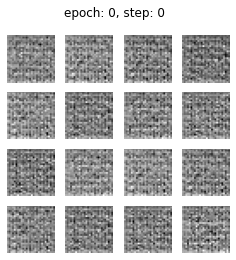

In [20]:

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)



The training loop is shown below. This will display generated images each epoch and will take around 30 minutes to complete. Notice too that we add the KLD loss to the binary crossentropy loss before we get the gradients and update the weights.

As you might expect, the initial 16 images will look random but it will improve overtime as the network learns and you'll see images that resemble the MNIST dataset.


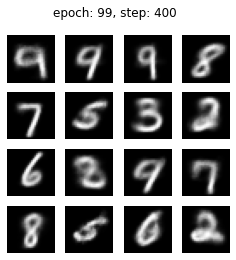

Epoch: 99 step: 400 mean loss = 142.27293


In [21]:

# Training loop. 


for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss, shape -1 flattens it
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784
      
      # add KLD regularization loss
      loss += sum(vae.losses)  

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

